In [ ]:
# parameters
grid_size = 3 # size of averaging window for calculating AOD or other products
band = "55"
varPM = "PMc"
varAOD = "nAODm"
root_path = "/content/drive/MyDrive"

# from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
from sklearn import preprocessing
import os
from google.colab import drive
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

print(tf.test.gpu_device_name())


/device:GPU:0


In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
name = "fAOD_PM" + "_g"+str(grid_size) + "_" + band + ".csv"
path = os.path.join(root_path, "final_data", name)
df = pd.read_csv(path)



#X = df[[varAOD, 'lat', 'long', 'Prob_bestm','d2m', 't2m', 'blh',
#       'sp', 'lai_hv', 'ws10', 'wd10', 'uvb',
#       'RH', 'DOY']]
X = df[[varAOD, 'lat', 'long', 'd2m', 't2m', 'blh',
       'sp',  'ws10', 'wd10', 'uvb',
       'RH', 'DOY']]

print(X.columns)
y = df[[varPM]]
y = y.to_numpy()

scaler = MinMaxScaler()
Xs = scaler.fit_transform(X)
print(Xs.shape)
print(y.shape)


Index(['nAODm', 'lat', 'long', 'Prob_bestm', 'd2m', 't2m', 'blh', 'sp',
       'lai_hv', 'ws10', 'wd10', 'uvb', 'RH', 'DOY'],
      dtype='object')
(19862, 14)
(19862, 1)


Data preparation

In [ ]:
cv = KFold(n_splits=10, random_state=1, shuffle=True)
i = 0
for train_index, test_index in cv.split(X):
  print("loop:", i)
  if i == 6:
    print( "TRAIN:", train_index, "TEST:", test_index)
    break
  else:
    i+=1
Xtrain = Xs[train_index]
ytrain = y[train_index]

Xtest = Xs[test_index]
ytest = y[test_index]

print(Xtrain.shape)
print(ytrain.shape)

loop: 0
loop: 1
loop: 2
loop: 3
loop: 4
loop: 5
loop: 6
TRAIN: [    0     4     5 ... 19859 19860 19861] TEST: [    1     2     3 ... 19843 19846 19850]
(17876, 14)
(17876, 1)


XGBoost

In [ ]:
from xgboost import XGBRegressor
scoring = ['r2','neg_mean_squared_error']
xgbr = XGBRegressor(objective='reg:squarederror', n_estimators=2000, seed = 123)
xgbr.fit(Xtrain, ytrain, verbose=True)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=2000,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=123, silent=None, subsample=1, verbosity=1)

Time of execution: 0.1592569351196289
RMSE:  8.1
MAE:  6.26
Pearsons R2 correlation: 0.799


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


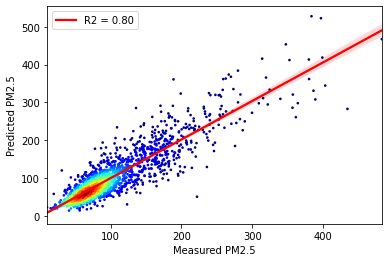

In [ ]:
# make predictions on the test set
dftest = df.loc[test_index]

import time
start = time.time()
# prediction on validation data
dftest["y_pred"] = xgbr.predict(Xtest)
print("Time of execution:",  (time.time() - start))

def NominalPM(row):
    return row["y_pred"]/((1-row["RH"])**(-1))
dftest["PMp"] = dftest.apply(NominalPM, axis = 1)

print ("RMSE: ", np.round(mean_squared_error(dftest["PMp"], dftest["PM2.5"], squared=False),2))
print ("MAE: ", np.round(mean_absolute_error(dftest["PM2.5"], dftest["PMp"]),2))
from scipy.stats import pearsonr
corr, _ = pearsonr(dftest["y_pred"], dftest["PMc"])
print('Pearsons R2 correlation: %.3f' % corr**2)


import matplotlib.pyplot as plt
import seaborn as sb
# regression plot
fig, ax = plt.subplots()
# plt.rc('font', family='serif')
ax = sb.regplot(dftest["y_pred"], dftest["PMc"], data = df,
            line_kws={"color": "red"}, scatter=False)
plt.legend(['R2 = {:.2f}'.format(np.round(corr, 2))])
plt.xlabel('Measured PM2.5')
plt.ylabel('Predicted PM2.5')


# plt.figure()
# plt.hist(y)
# plt.show()
from scipy.stats import gaussian_kde
x, y = dftest["y_pred"].to_numpy(), dftest["PMc"].to_numpy()


# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)


ax.scatter(x, y, c=z, s=7, edgecolor='', cmap='jet')
plt.show()

In [ ]:
# Save model
output_path = os.path.join(root_path , "PythonCodes", "PMXGB")
xgbr.save_model(output_path)
print(output_path)

/content/drive/MyDrive/PythonCodes/PMXGB
